In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import optuna
import lightgbm as lgb

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report, 
    f1_score, accuracy_score, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from phik import phik_matrix

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# EDA

In [3]:
train = pd.read_csv('data/train.csv')
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [4]:
train.id.nunique() == train.shape[0]

True

In [5]:
train.set_index('id', inplace=True)

Смотрим распределение таргета

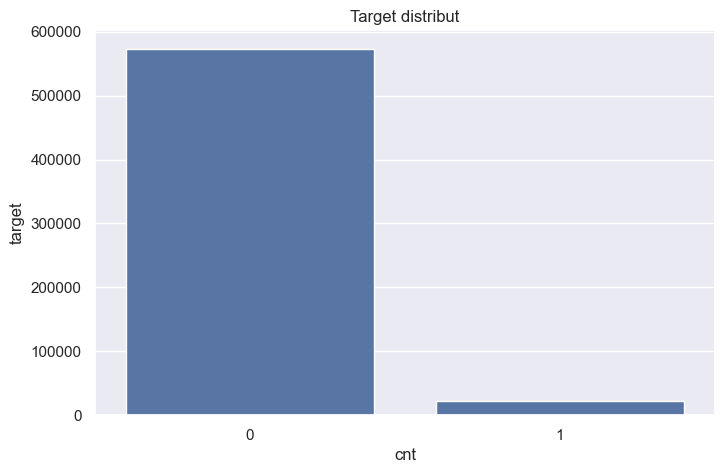

In [6]:
sns.set()
plt.figure(figsize=(8, 5))
sns.countplot(data=train, x='target')
plt.title('Target distribut')
plt.xlabel('cnt')
plt.ylabel('target')
plt.show()

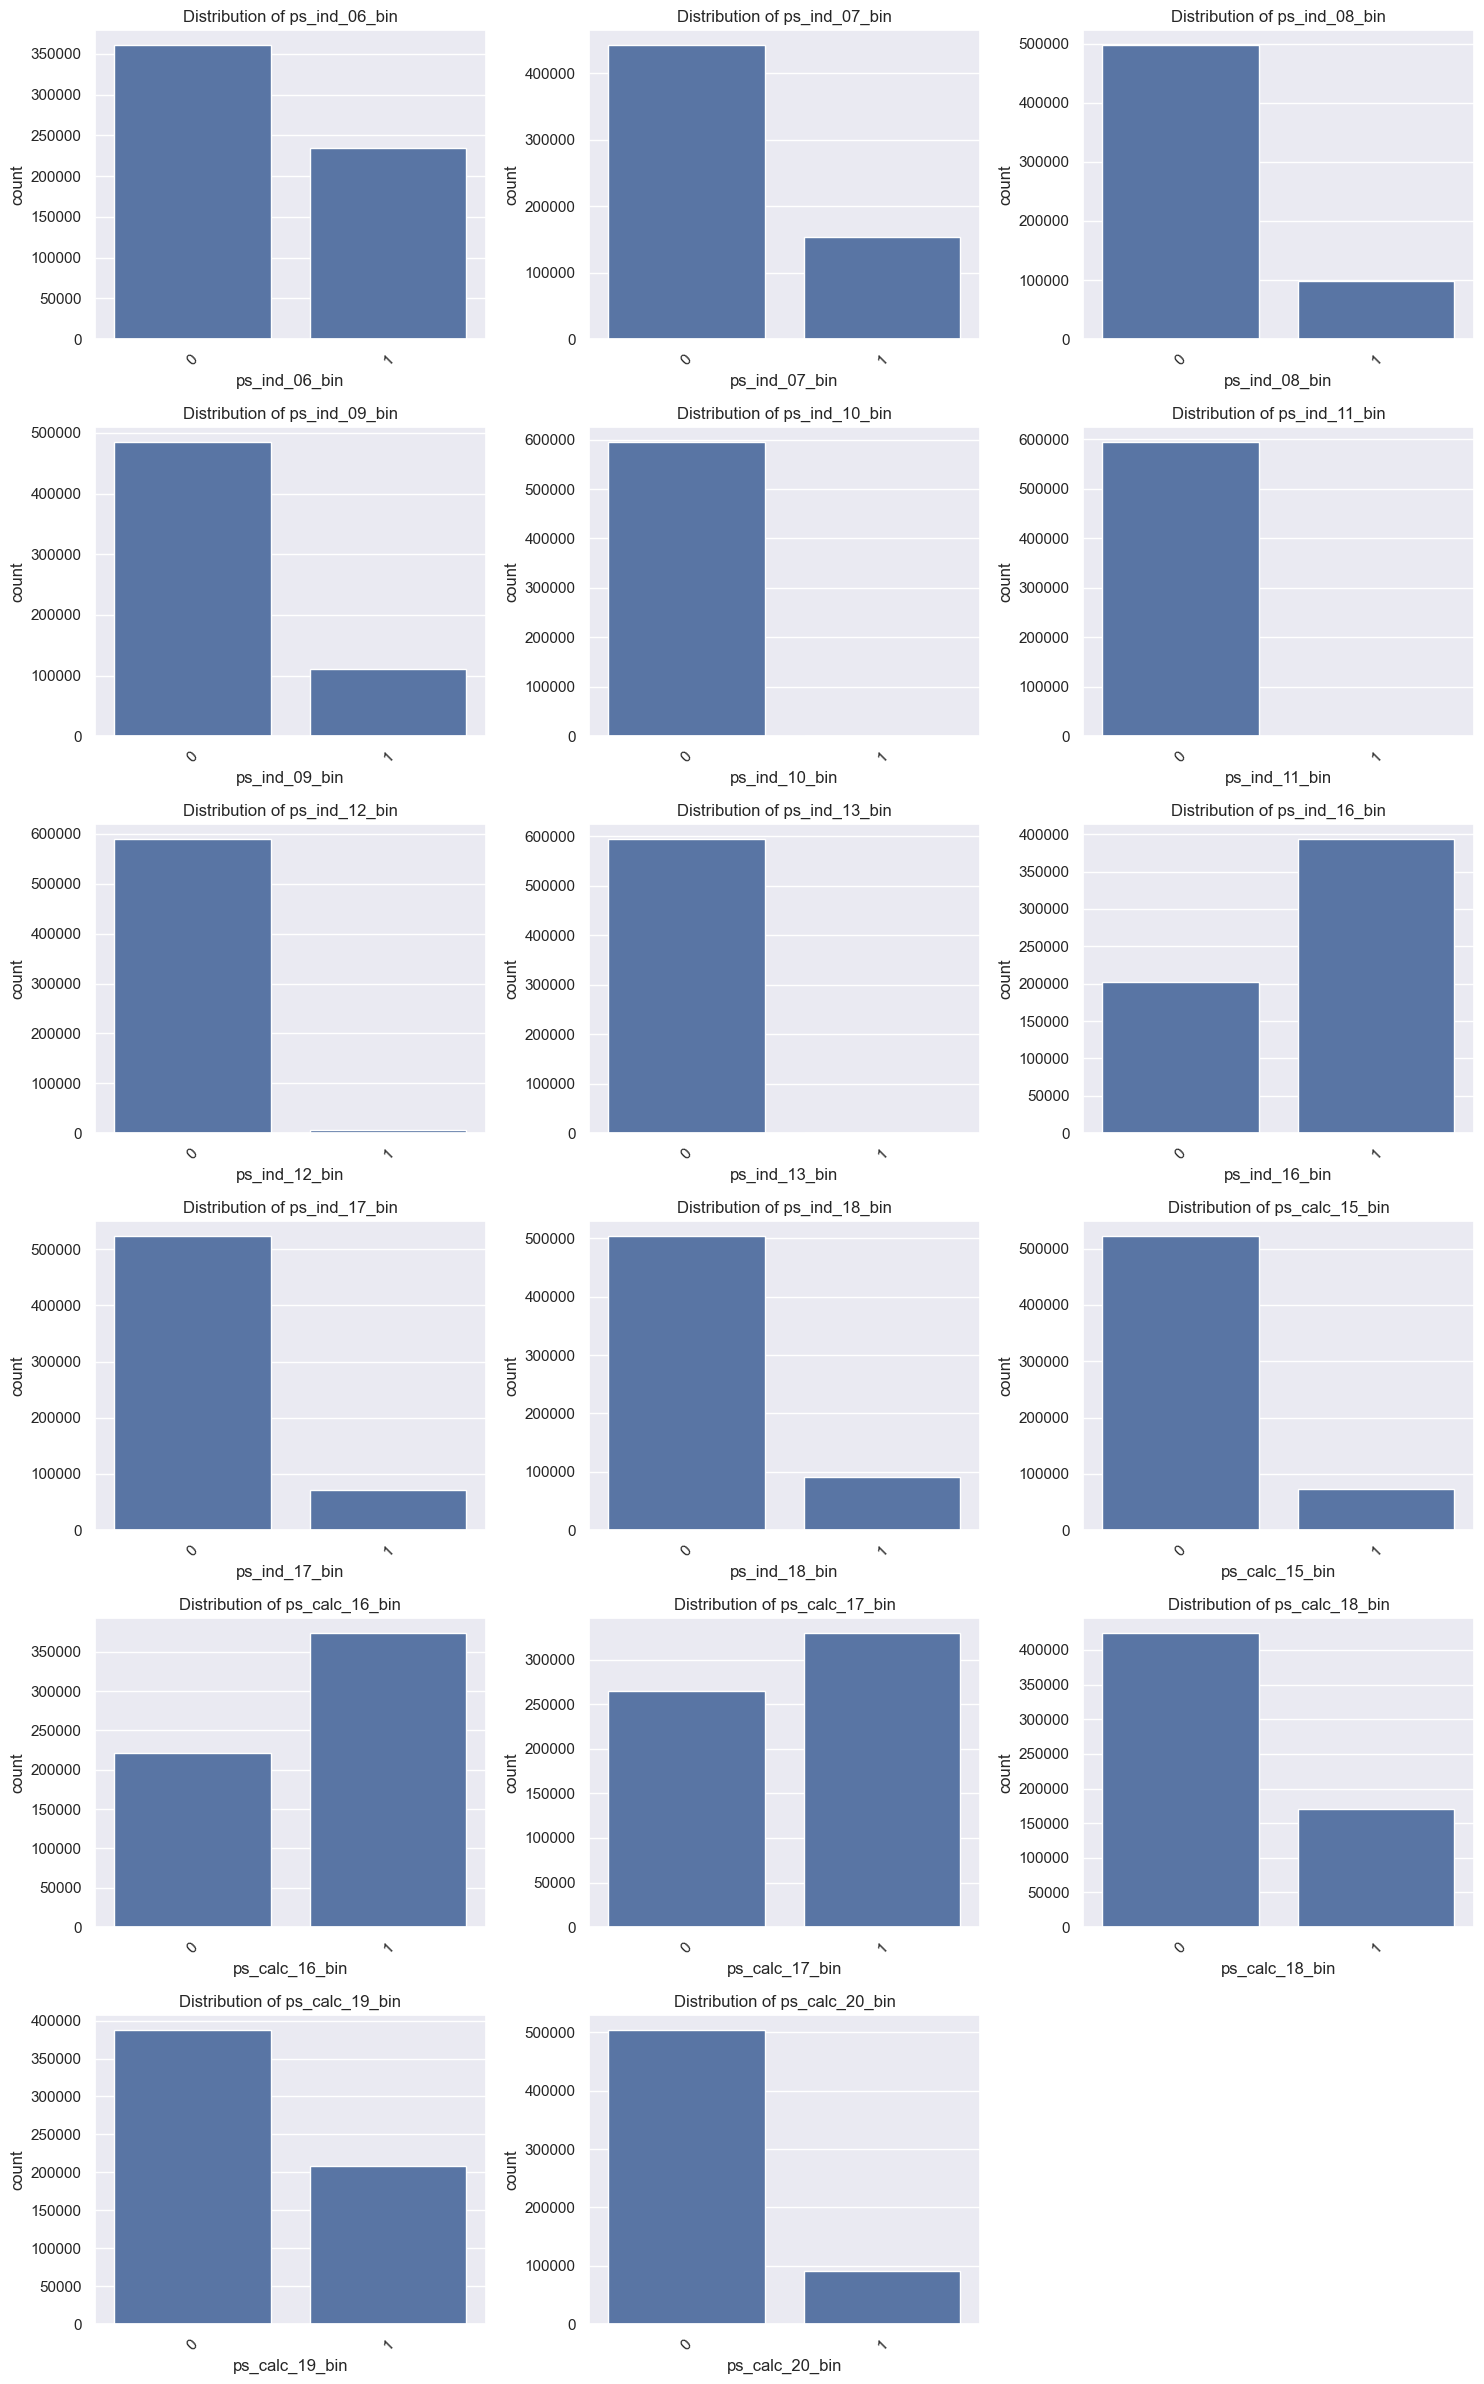

In [7]:

bin_features = [x for x in list(train.columns) if 'bin' in x]

def cat_plots(data, features, cols=3, hue=None):
    n_features = len(features)
    rows = math.ceil(n_features / cols)
    
    plt.figure(figsize=(cols * 5, rows * 4))
    
    for i, col in enumerate(features):
        plt.subplot(rows, cols, i + 1)
        sns.countplot(data=data, x=col, hue=hue) 
        plt.title(f'Distribution of {col}')
        plt.xticks(rotation=45)
        
    plt.tight_layout()
    plt.show()

cat_plots(train, bin_features)

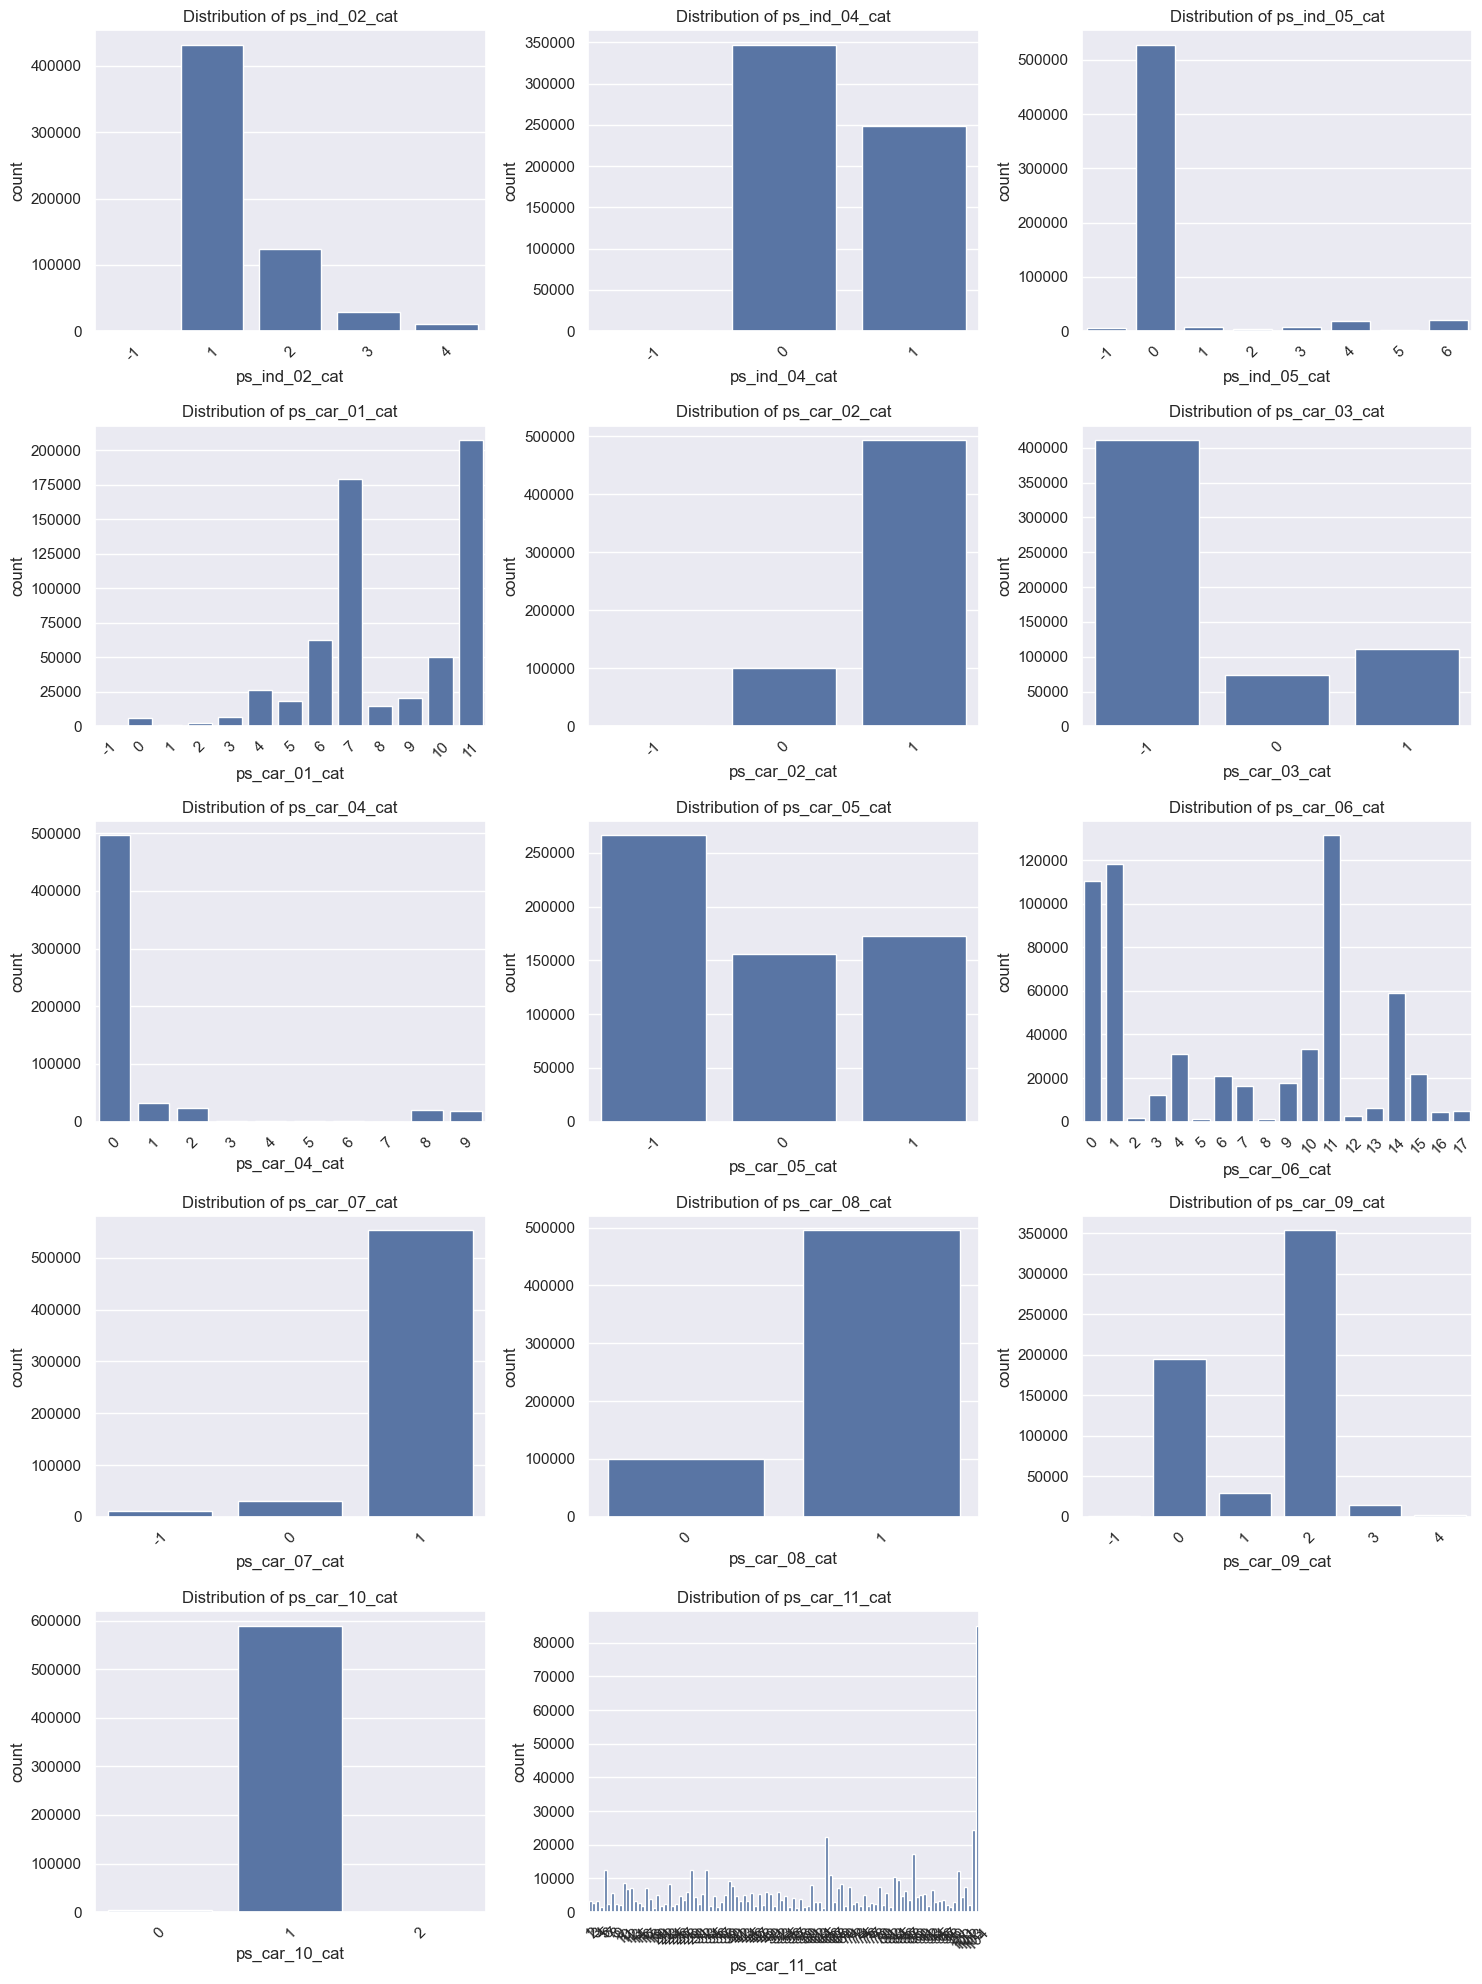

In [8]:
cat_features = [x for x in list(train.columns) if 'cat' in x]
cat_plots(train, cat_features)

дропну ps_car_03_cat и ps_car_05_cat, слишком много пропусков

In [9]:
train.drop(['ps_car_03_cat', 'ps_car_05_cat'], axis=1, inplace=True)
cat_features = [x for x in list(train.columns) if 'cat' in x]

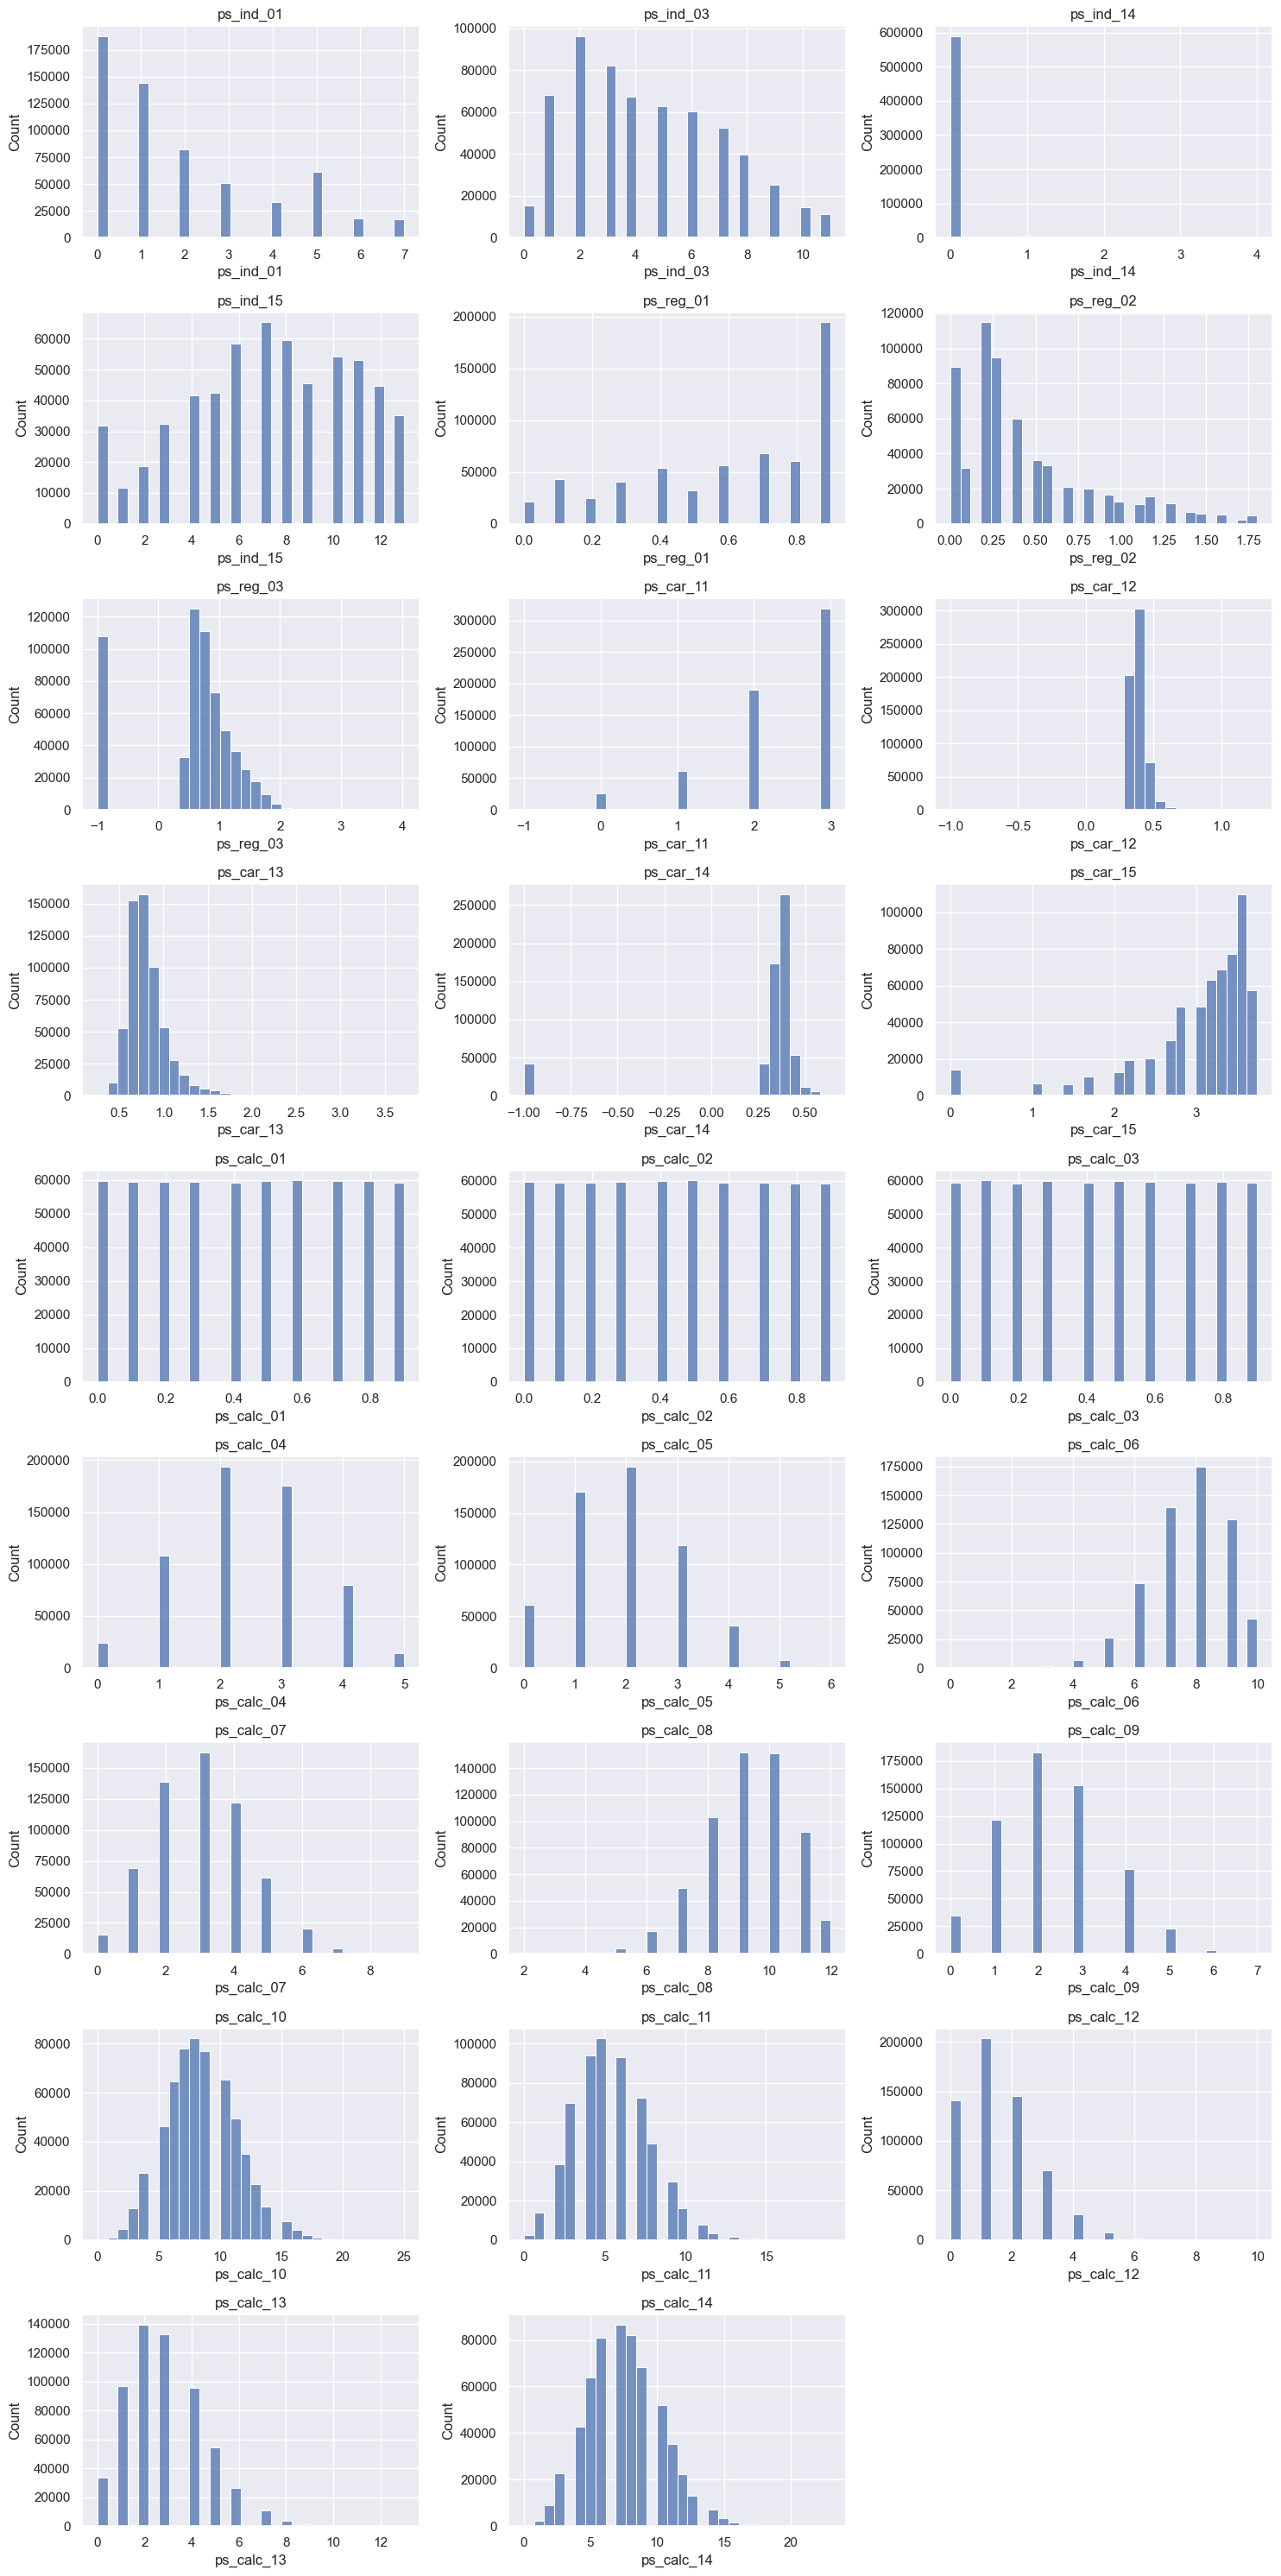

In [10]:
num_features = [x for x in list(train.columns) if 'cat' not in x and 'bin' not in x and x not in 'target']
num_features
plt.figure(figsize=(15, 30))

for i, col in enumerate(num_features):
    plt.subplot(9, 3, i + 1)
    sns.histplot(train[col], kde=False, bins=30)
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [11]:
df = train.copy()
df.replace(-1, np.nan, inplace=True)

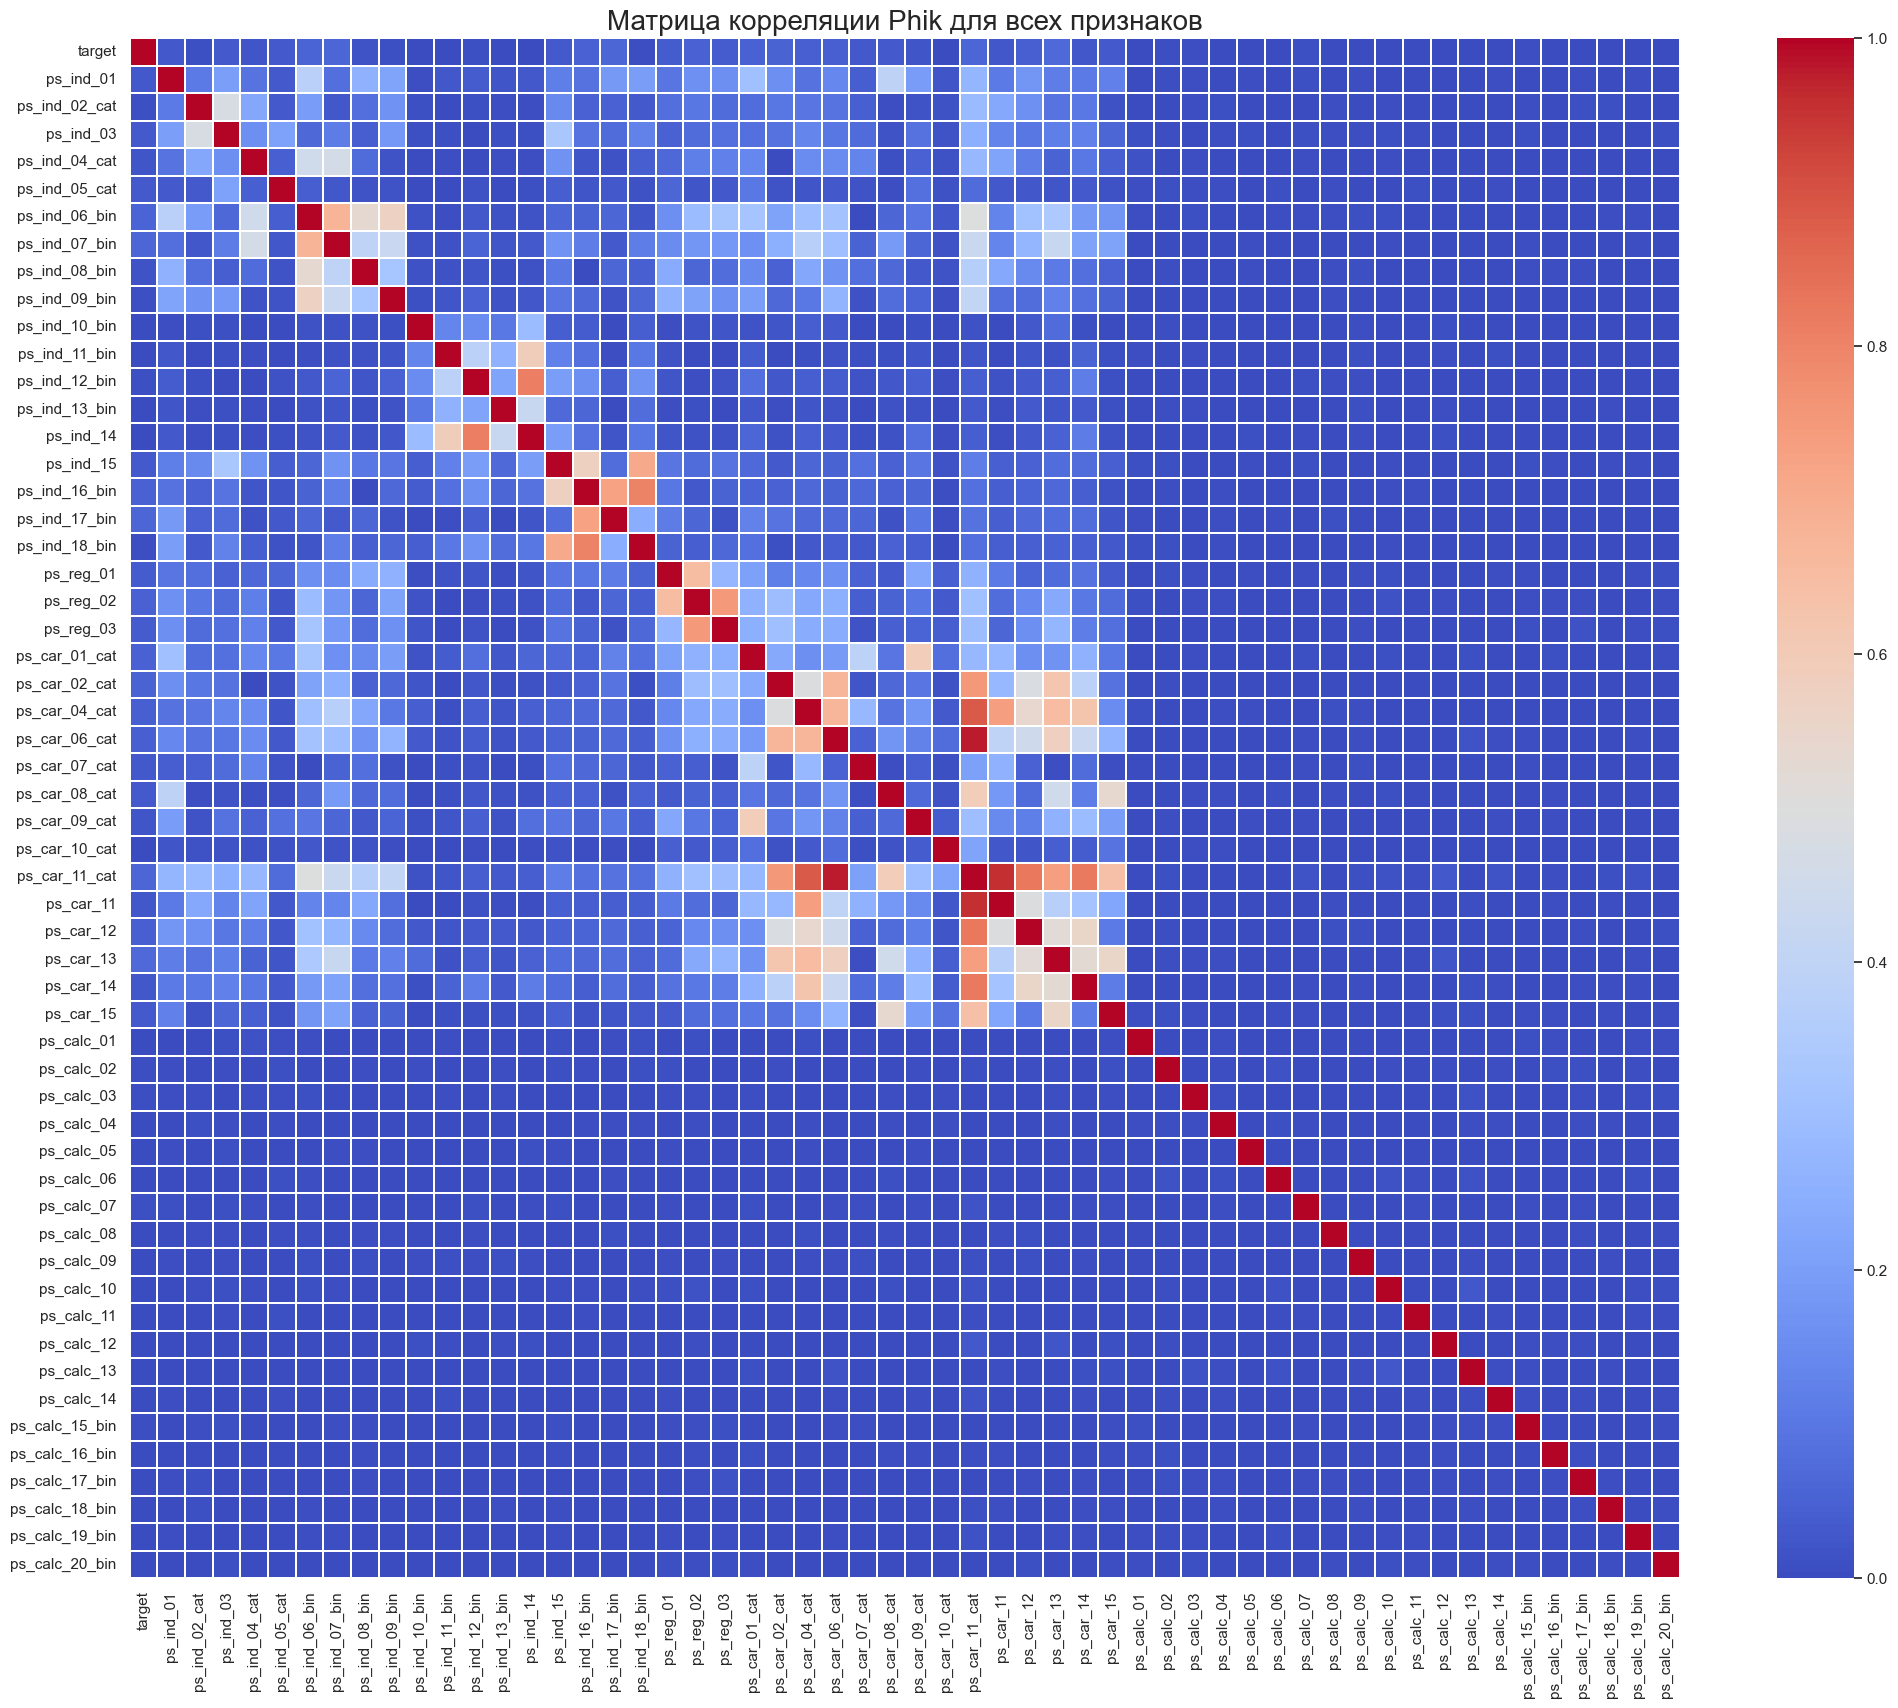

In [12]:
phik_matrix = df.sample(200000).phik_matrix(interval_cols=num_features)

plt.figure(figsize=(25, 20))

sns.heatmap(phik_matrix,
            annot=False,
            cmap='coolwarm',
            linewidths=0.1)

plt.title('Матрица корреляции Phik для всех признаков', fontsize=20)
plt.show()

In [13]:
threshold = 0.85

import numpy as np
upper = phik_matrix.where(np.triu(np.ones(phik_matrix.shape), k=1).astype(bool))

columns_to_check = [column for column in upper.columns if any(upper[column] > threshold)]

print(f"Список на удаление: {columns_to_check}")

Список на удаление: ['ps_car_11_cat', 'ps_car_11']


Дропну только `ps_ind_14` и `ps_car_11_cat`, потому что `ps_car_11` сильно коррелирует только с `ps_car_11_cat`

In [14]:
train.drop(['ps_car_11_cat', 'ps_ind_14'], axis=1, inplace=True)

Проверим calc стобцы, потому что они странно выделяются полным отсутствием корреляции

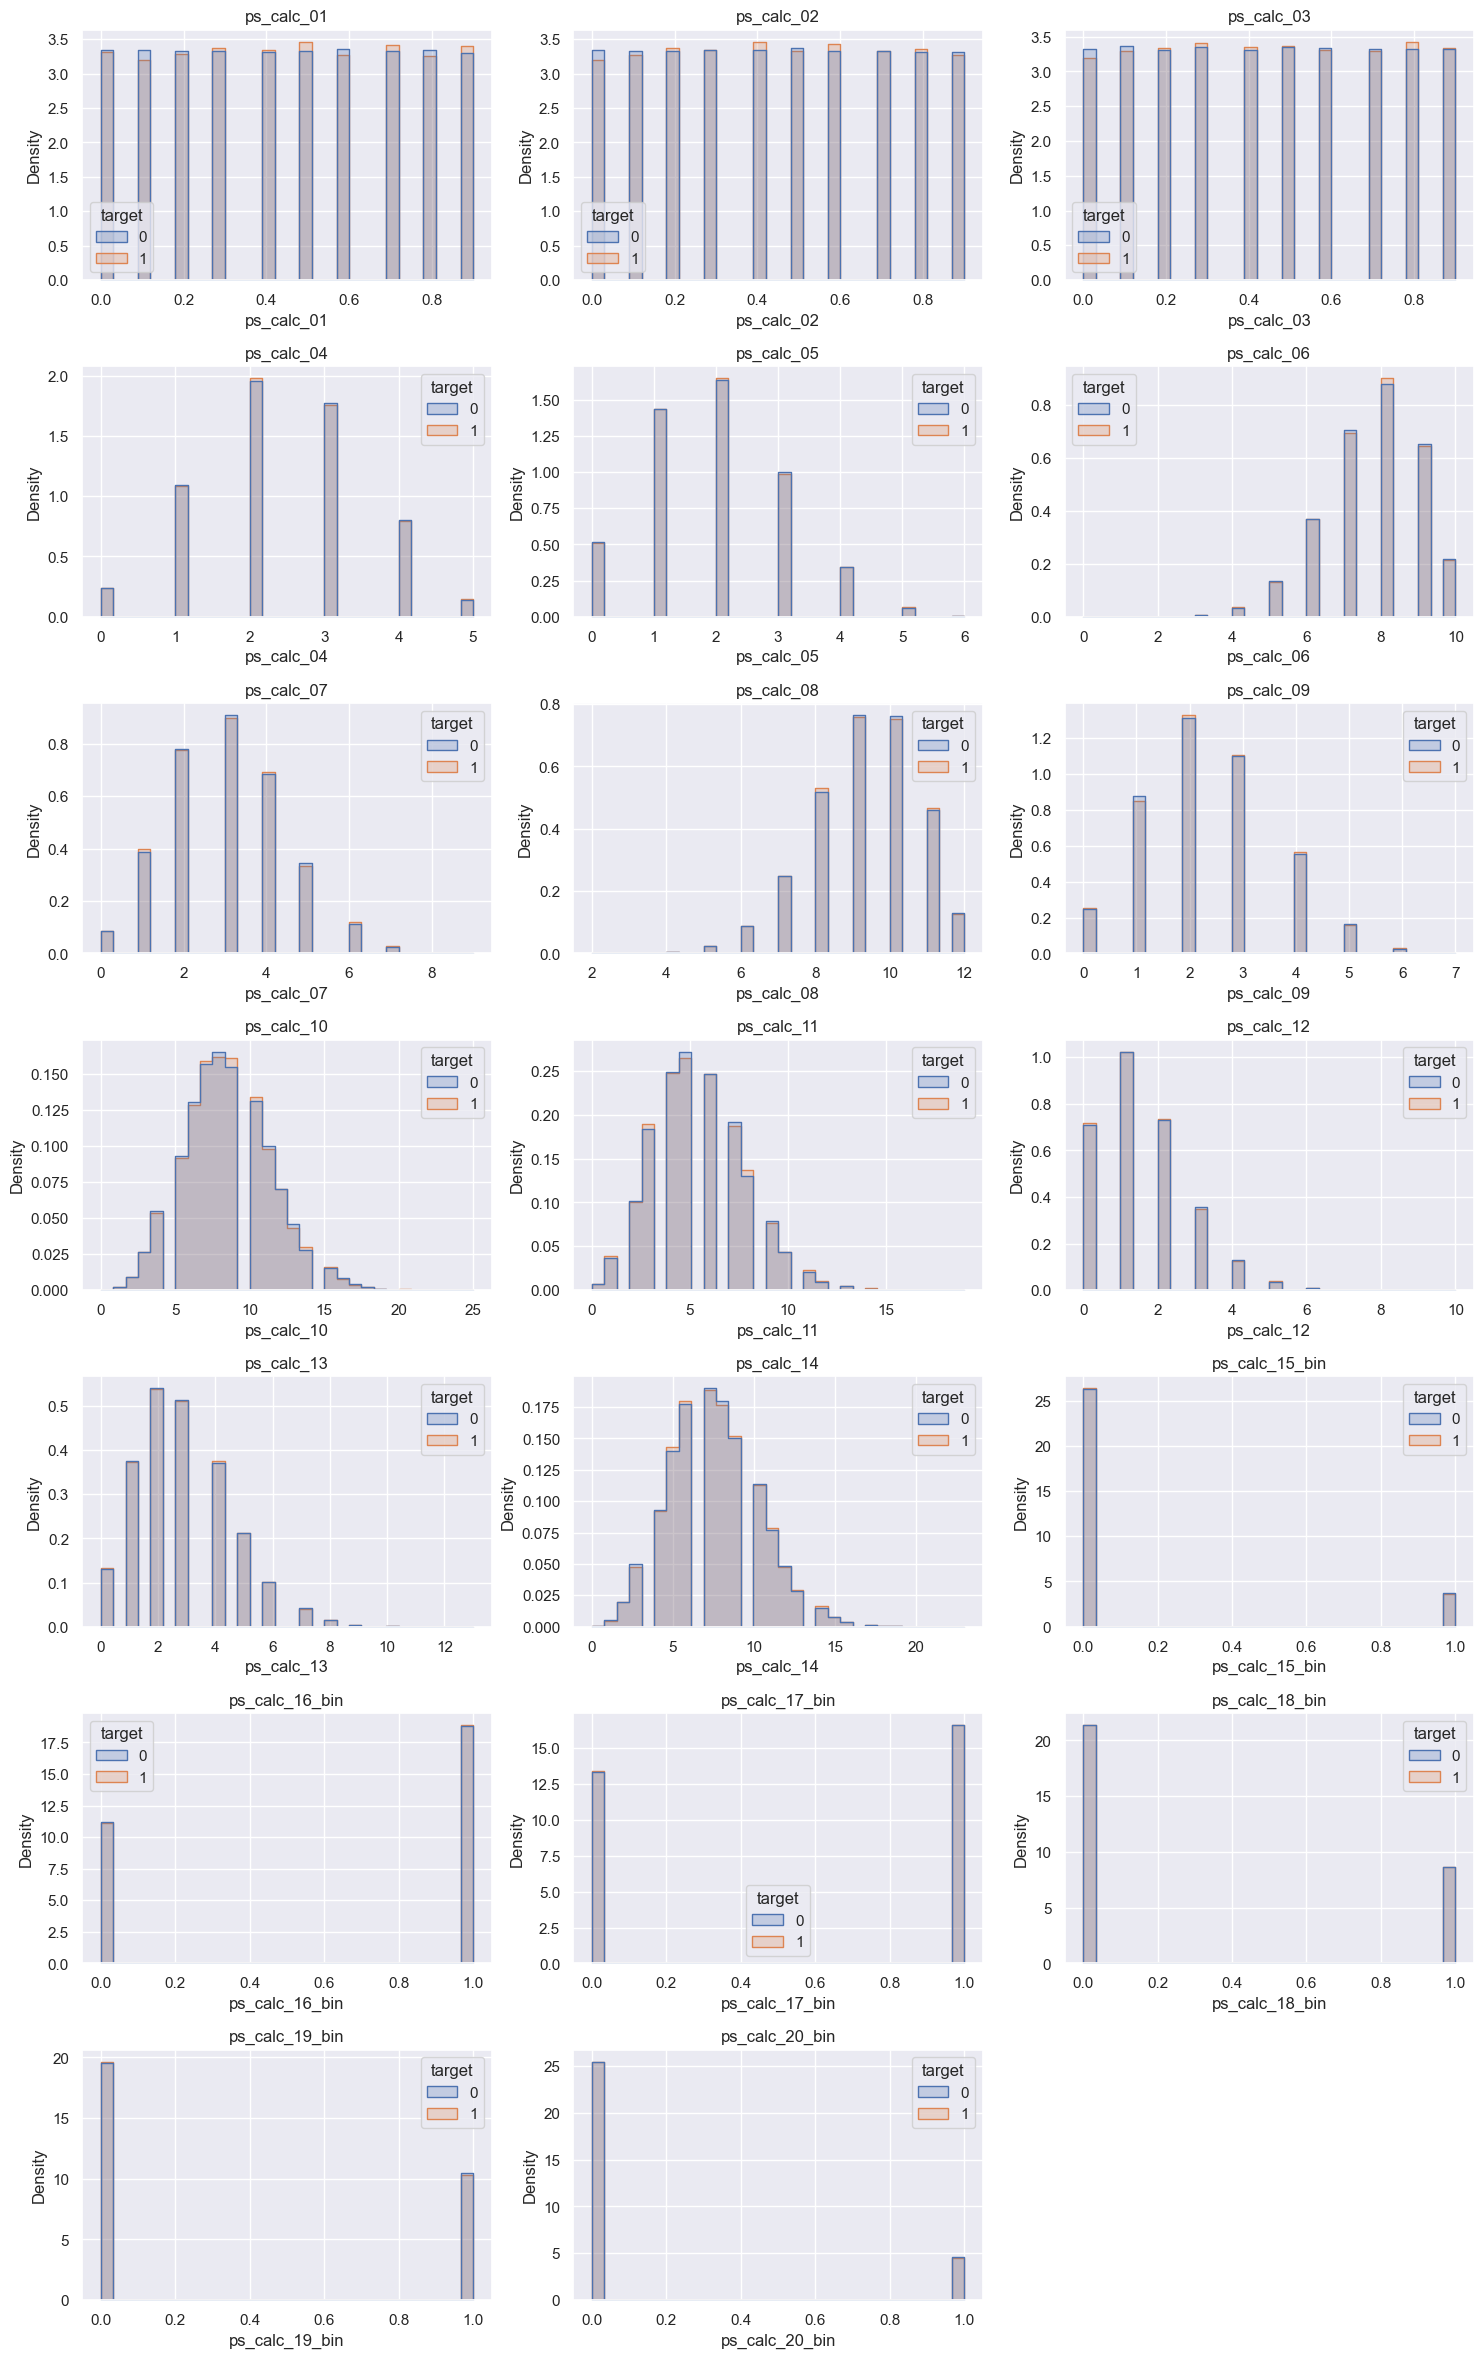

In [15]:
calc_features = [x for x in list(train.columns) if 'calc' in x]

plt.figure(figsize=(15, 30))

for i, col in enumerate(calc_features):
    plt.subplot(9, 3, i + 1)
    sns.histplot(data=train, x=col, hue='target', stat="density", common_norm=False, kde=False, bins=30, element="step")
    plt.title(col)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

Таргет никак не зависит от calc столбцов поэтому их можно дропнуть, скорее всего это шум

In [16]:
train.drop(calc_features, axis=1, inplace=True)
train.head()

,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,0,4,1,0,0,1,2,0.400000,0.883679,0.370810,3.605551
9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,0,11,1,1,2,1,3,0.316228,0.618817,0.388716,2.449490
13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,0,14,1,1,2,1,1,0.316228,0.641586,0.347275,3.316625
16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,11,1,1,3,1,1,0.374166,0.542949,0.294958,2.000000
17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,0,14,1,1,2,1,3,0.316070,0.565832,0.365103,2.000000


# Baseline

In [17]:
X = train.drop('target', axis=1)
y = train['target']

num_features = [x for x in list(train.columns) if 'cat' not in x and 'bin' not in x and x not in ['target']]
cat_features = [x for x in list(train.columns) if 'cat' in x] 

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
    ('num', StandardScaler(), num_features)
])

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l1',
        solver='liblinear',
        class_weight='balanced',
        C=0.1, 
        random_state=42,
        max_iter=1000
    ))
])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

clf.fit(X_train, y_train)
probs = clf.predict_proba(X_val)[:, 1]

auc = roc_auc_score(y_val, probs)
print(f"Baseline ROC-AUC: {auc:.4f}")
print(f"Baseline Gini: {2 * auc - 1:.4f}")

Baseline ROC-AUC: 0.6265
Baseline Gini: 0.2529


In [18]:
preds = clf.predict(X_val)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.97      0.62      0.76    114704
           1       0.05      0.55      0.10      4339

    accuracy                           0.62    119043
   macro avg       0.51      0.59      0.43    119043
weighted avg       0.94      0.62      0.73    119043



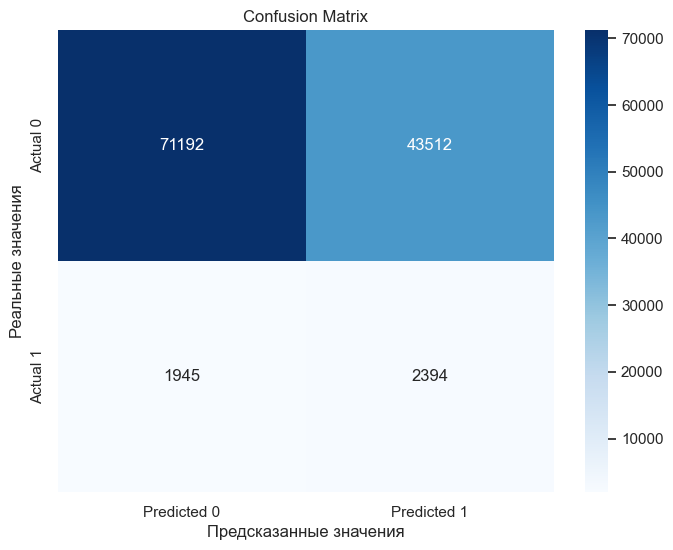

In [19]:
cm = confusion_matrix(y_val, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.ylabel('Реальные значения')
plt.xlabel('Предсказанные значения')
plt.title('Confusion Matrix')
plt.show()

C:\Users\serge\AppData\Local\Temp\ipykernel_17856\3607672240.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


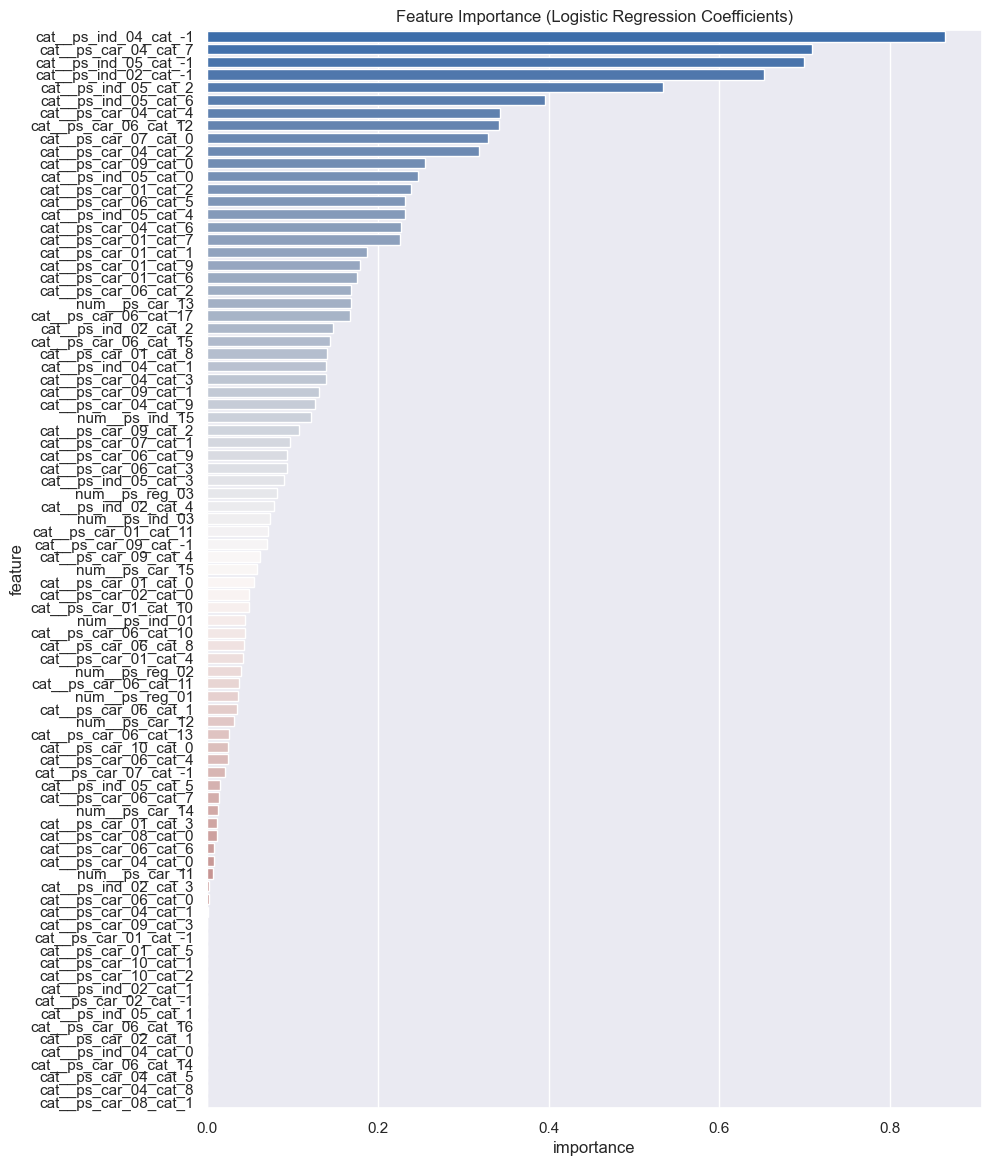

In [20]:

model = clf.steps[-1][1] 
feature_names = clf.steps[0][1].get_feature_names_out()

feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': model.coef_[0]
})

feature_importance['importance'] = feature_importance['importance'].abs()
feature_importance = feature_importance.sort_values(by='importance', ascending=False)

plt.figure(figsize=(10, 14))
sns.barplot(
    x='importance', 
    y='feature', 
    data=feature_importance, 
    palette='vlag'
)
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

# RandomForest

In [21]:
train.replace(-1, np.nan, inplace=True)
train.isna().sum()

target                0
ps_ind_01             0
ps_ind_02_cat       216
ps_ind_03             0
ps_ind_04_cat        83
ps_ind_05_cat      5809
ps_ind_06_bin         0
ps_ind_07_bin         0
ps_ind_08_bin         0
ps_ind_09_bin         0
ps_ind_10_bin         0
ps_ind_11_bin         0
ps_ind_12_bin         0
ps_ind_13_bin         0
ps_ind_15             0
ps_ind_16_bin         0
ps_ind_17_bin         0
ps_ind_18_bin         0
ps_reg_01             0
ps_reg_02             0
ps_reg_03        107772
ps_car_01_cat       107
ps_car_02_cat         5
ps_car_04_cat         0
ps_car_06_cat         0
ps_car_07_cat     11489
ps_car_08_cat         0
ps_car_09_cat       569
ps_car_10_cat         0
ps_car_11             5
ps_car_12             1
ps_car_13             0
ps_car_14         42620
ps_car_15             0
dtype: int64

In [22]:
X = train.drop('target', axis=1)
y = train['target']

In [23]:
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features)
], remainder='passthrough')

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=200,      
        max_depth=12,         
        min_samples_leaf=50,   
        class_weight='balanced', 
        random_state=42,
        n_jobs=-1              
    ))
])

X = df.drop('target', axis=1)
y = df['target']
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Обучение...")
rf_pipeline.fit(X_train, y_train)

probs = rf_pipeline.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, probs)

print(f"Random Forest ROC-AUC: {auc:.4f}")
print(f"Random Forest Gini: {2 * auc - 1:.4f}")

Обучение...
Random Forest ROC-AUC: 0.6307
Random Forest Gini: 0.2614


In [24]:
preds = rf_pipeline.predict(X_val)
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.97      0.76      0.85    114704
           1       0.06      0.41      0.10      4339

    accuracy                           0.75    119043
   macro avg       0.52      0.58      0.48    119043
weighted avg       0.94      0.75      0.82    119043



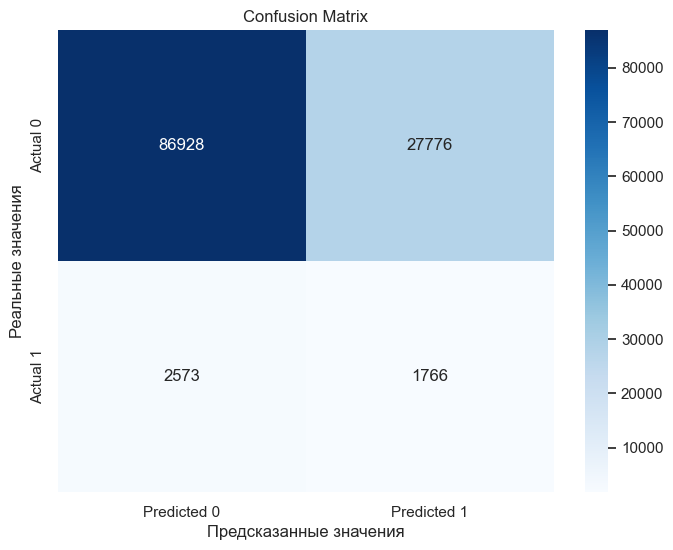

In [25]:
cm = confusion_matrix(y_val, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.ylabel('Реальные значения')
plt.xlabel('Предсказанные значения')
plt.title('Confusion Matrix')
plt.show()

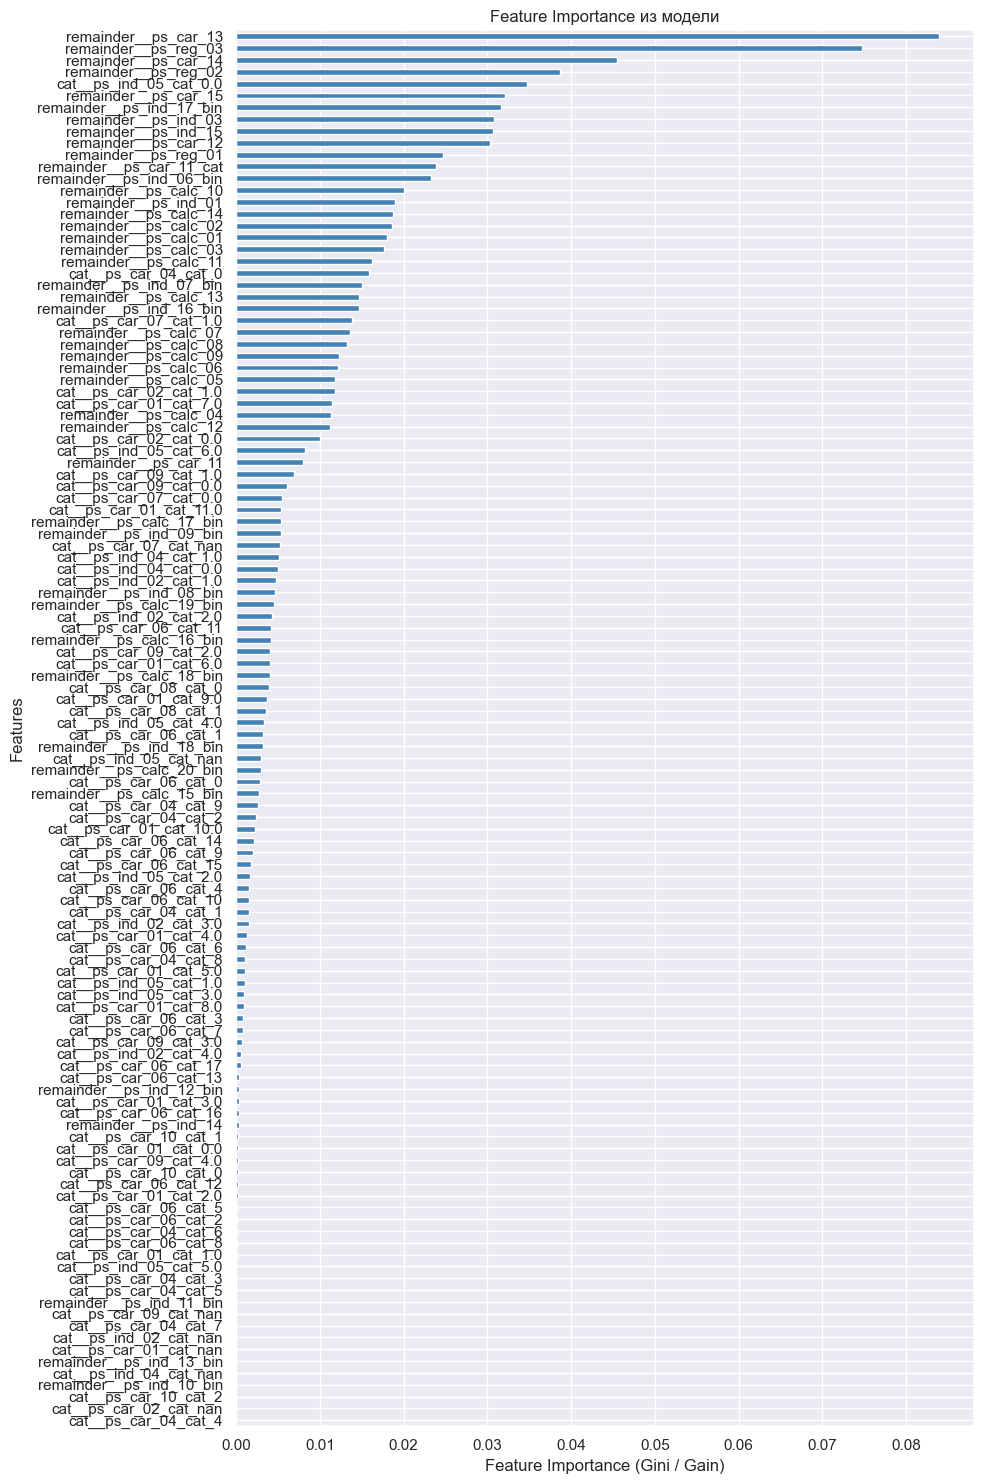

In [26]:
model = rf_pipeline.named_steps['classifier']
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = model.feature_importances_

feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=True)

plt.figure(figsize=(10, 15))
feat_imp.plot(kind='barh', color='steelblue')

plt.xlabel('Feature Importance (Gini / Gain)')
plt.ylabel('Features')
plt.title('Feature Importance из модели')
plt.tight_layout()
plt.show()

# LGBM

In [27]:
X = train.drop('target', axis=1)
y = train['target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# X_train, X_val, y_train, y_val = train_test_split(
#     X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
# )

cat_features = [col for col in X.columns if 'cat' in col]
num_features = [col for col in X.columns if col not in cat_features]

print(f"Итоговое разделение:")
print(f"Обучение (Train): {X_train.shape[0]} строк")
# print(f"Валидация (Val):  {X_val.shape[0]} строк")
print(f"Тест (Test):      {X_test.shape[0]} строк")

Итоговое разделение:
Обучение (Train): 476169 строк
Тест (Test):      119043 строк


In [28]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(X_train[cat_features])

X_train_cat_mat = ohe.transform(X_train[cat_features])
X_train_cat_df = pd.DataFrame(
    X_train_cat_mat, 
    columns=ohe.get_feature_names_out(cat_features), 
    index=X_train.index
)
X_train = pd.concat([X_train_cat_df, X_train[num_features]], axis=1)

X_test_cat_mat = ohe.transform(X_test[cat_features])
X_test_cat_df = pd.DataFrame(
    X_test_cat_mat, 
    columns=ohe.get_feature_names_out(cat_features), 
    index=X_test.index
)
X_test = pd.concat([X_test_cat_df, X_test[num_features]], axis=1)

print(f"Признаков в Train: {X_train.shape[1]}")
print(f"Признаков в Test:  {X_test.shape[1]}") 
print(f"Индексы Train совпадают: {all(X_train.index == y_train.index)}")

Признаков в Train: 96
Признаков в Test:  96
Индексы Train совпадают: True


In [29]:
# X_train = X_train.astype('float32')
# # X_val = X_val.astype('float32')
# X_test = X_test.astype('float32')

In [30]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 30), 
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 2000),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-3, 10.0, log=True),
    }

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []

    for train_idx, val_idx in skf.split(X_train, y_train):
        X_tr_fold, X_val_fold = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr_fold, y_val_fold = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            X_tr_fold, y_tr_fold,
            eval_set=[(X_val_fold, y_val_fold)],
            callbacks=[
                lgb.early_stopping(50), 
                lgb.log_evaluation(0)
            ]
        )

        preds = model.predict_proba(X_val_fold)[:, 1]
        cv_scores.append(roc_auc_score(y_val_fold, preds))

    return np.mean(cv_scores)


In [31]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("\n" + "="*30)
print(f"Лучший AUC: {study.best_value:.5f}")
print("Лучшие параметры:", study.best_params)

[I 2025-12-24 23:48:55,318] A new study created in memory with name: no-name-b25edc20-912d-4646-84f9-68a02a308cd2


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.632521
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.635353
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.627466
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.628083
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.633741


[I 2025-12-24 23:49:14,131] Trial 0 finished with value: 0.6314325539257999 and parameters: {'scale_pos_weight': 4.562687315772454, 'learning_rate': 0.0327222512667971, 'num_leaves': 197, 'max_depth': 3, 'min_child_samples': 1122, 'lambda_l1': 0.2701624491476382}. Best is trial 0 with value: 0.6314325539257999.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[78]	valid_0's auc: 0.63357
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[81]	valid_0's auc: 0.635301
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[73]	valid_0's auc: 0.63136
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.630987
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.634684


[I 2025-12-24 23:49:44,817] Trial 1 finished with value: 0.6331804700059115 and parameters: {'scale_pos_weight': 26.377579290630656, 'learning_rate': 0.03532836563388937, 'num_leaves': 124, 'max_depth': 11, 'min_child_samples': 212, 'lambda_l1': 0.052169977176759676}. Best is trial 1 with value: 0.6331804700059115.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.639861
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.638657
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.631479
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	valid_0's auc: 0.632403
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[84]	valid_0's auc: 0.635373


[I 2025-12-24 23:50:11,901] Trial 2 finished with value: 0.6355545093360865 and parameters: {'scale_pos_weight': 21.90970730933814, 'learning_rate': 0.037293700851211815, 'num_leaves': 188, 'max_depth': 9, 'min_child_samples': 865, 'lambda_l1': 0.005190944489100718}. Best is trial 2 with value: 0.6355545093360865.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.636272
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.635207
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[93]	valid_0's auc: 0.630076
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	valid_0's auc: 0.630857
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.634292


[I 2025-12-24 23:50:40,418] Trial 3 finished with value: 0.6333405256654927 and parameters: {'scale_pos_weight': 17.728371473590446, 'learning_rate': 0.03827029045762654, 'num_leaves': 114, 'max_depth': 9, 'min_child_samples': 307, 'lambda_l1': 7.564301400455153}. Best is trial 2 with value: 0.6355545093360865.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.63603
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.63863
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.631065
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.629923
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.637099


[I 2025-12-24 23:51:07,154] Trial 4 finished with value: 0.6345495768950524 and parameters: {'scale_pos_weight': 15.787855647002765, 'learning_rate': 0.011702555317590306, 'num_leaves': 116, 'max_depth': 7, 'min_child_samples': 905, 'lambda_l1': 0.012526324571725528}. Best is trial 2 with value: 0.6355545093360865.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.639008
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.639243
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.635064
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.631514
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.63677


[I 2025-12-24 23:51:37,623] Trial 5 finished with value: 0.6363198063436496 and parameters: {'scale_pos_weight': 23.10279727702553, 'learning_rate': 0.030549706459446074, 'num_leaves': 150, 'max_depth': 12, 'min_child_samples': 1361, 'lambda_l1': 0.0015398701058218713}. Best is trial 5 with value: 0.6363198063436496.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's auc: 0.637781
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.636201
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[53]	valid_0's auc: 0.629028
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[98]	valid_0's auc: 0.626993
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[57]	valid_0's auc: 0.635684


[I 2025-12-24 23:52:08,332] Trial 6 finished with value: 0.6331373864828345 and parameters: {'scale_pos_weight': 26.10996145942294, 'learning_rate': 0.045786384314399006, 'num_leaves': 167, 'max_depth': 12, 'min_child_samples': 862, 'lambda_l1': 0.8218853409699242}. Best is trial 5 with value: 0.6363198063436496.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.637165
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.63819
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.630757
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.631618
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.637545


[I 2025-12-24 23:52:34,027] Trial 7 finished with value: 0.6350549686457485 and parameters: {'scale_pos_weight': 7.641005283128612, 'learning_rate': 0.012215764748225121, 'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 608, 'lambda_l1': 0.0026726229403170113}. Best is trial 5 with value: 0.6363198063436496.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.639018
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.63975
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.633217
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.635063
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.637877


[I 2025-12-24 23:52:59,270] Trial 8 finished with value: 0.6369849348646092 and parameters: {'scale_pos_weight': 1.6121079233715316, 'learning_rate': 0.028672663516556604, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 1840, 'lambda_l1': 0.2914229378224136}. Best is trial 8 with value: 0.6369849348646092.


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's auc: 0.639242
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.63804
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.62935
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[96]	valid_0's auc: 0.631521
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[89]	valid_0's auc: 0.634515


[I 2025-12-24 23:53:29,636] Trial 9 finished with value: 0.6345336985751603 and parameters: {'scale_pos_weight': 17.357302098523125, 'learning_rate': 0.03341155125371188, 'num_leaves': 270, 'max_depth': 11, 'min_child_samples': 889, 'lambda_l1': 0.014783061015476422}. Best is trial 8 with value: 0.6369849348646092.



Лучший AUC: 0.63698
Лучшие параметры: {'scale_pos_weight': 1.6121079233715316, 'learning_rate': 0.028672663516556604, 'num_leaves': 119, 'max_depth': 7, 'min_child_samples': 1840, 'lambda_l1': 0.2914229378224136}


In [32]:
final_params = {
    'objective': 'binary',
    'metric': 'auc',
    'verbosity': -1,
    'random_state': 42,
    **study.best_params
}

print("Обучение...")
final_model = lgb.LGBMClassifier(**final_params)
final_model.fit(X_train, y_train)

test_probs = final_model.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_probs)
test_gini = 2 * test_auc - 1

print("\n" + "="*30)
print(f"Результаты на тесте:")
print(f"AUC:  {test_auc:.5f}")
print(f"Gini: {test_gini:.5f}")
print("="*30)

Обучение...

Результаты на тесте:
AUC:  0.63937
Gini: 0.27874


In [33]:
def find_best_threshold(y_true, y_probs):
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]
    
    return best_threshold, best_f1


best_thresh, best_f1 = find_best_threshold(y_test, test_probs)

print(f"Оптимальный порог: {best_thresh:.4f}")
print(f"F1-score: {best_f1:.4f}")

y_pred_best = (test_probs >= best_thresh).astype(int)

from sklearn.metrics import classification_report
print("\nОтчет с новым порогом:")
print(classification_report(y_test, y_pred_best))

Оптимальный порог: 0.0826
F1-score: 0.1175

Отчет с новым порогом:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92    114704
           1       0.08      0.25      0.12      4339

    accuracy                           0.86    119043
   macro avg       0.52      0.57      0.52    119043
weighted avg       0.94      0.86      0.90    119043



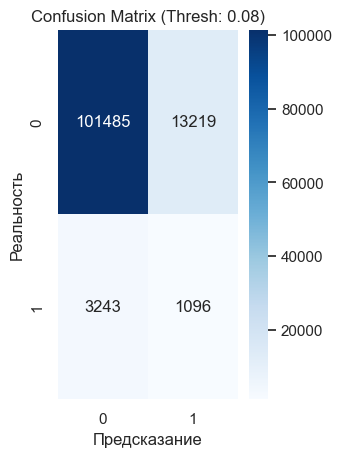

In [34]:
plt.subplot(1, 2, 1)
cm_best = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0', '1'], 
            yticklabels=['0', '1'])
plt.title(f'Confusion Matrix (Thresh: {best_thresh:.2f})')
plt.ylabel('Реальность')
plt.xlabel('Предсказание')
plt.show()